# Investing with Transaction Costs

The *standard mean-variance (Markowitz) portfolio selection model* determines an optimal investment portfolio that balances risk and expected return. In this notebook, we maximize the portfolio's expected return while constraining the admissible variance (risk) to a given maximum level. Please refer to the [annotated list of references](../literature.rst#portfolio-optimization) for more background information on portfolio optimization.

To this basic model, we add *transaction costs and fees*. These have two components:
* Fixed transaction costs, which are independent of the amount invested in each separate asset.
* Variable transaction fees, which are proportional to the amount invested in each asset.

This notebook focuses on constructing a new portfolio and assumes that the investor has no initial positions.

In [1]:
# Install dependencies
%pip install numpy scipy gurobipy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hidden cell to avoid licensing messages
# when docs are generated.
with gp.Model():
    pass

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2443533


WLS license 2443533 - registered to Gurobi GmbH


## Input Data

The following input data is used within the model:

- $S$: set of stocks
- $\mu$: vector of expected returns
- $\Sigma$: PSD variance-covariance matrix
    - $\sigma_{ij}$ covariance between returns of assets $i$ and $j$
    - $\sigma_{ii}$ variance of return of asset $i$

In [4]:
# Import some example data set
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

## Formulation

The model creates a new portfolio (no initial positions held by the investor) by maximizing the expected net return while ensuring that the variance of the portfolio return does not exceed a specified level. It also accounts for the impact of transaction costs on the available investment budget.

The transaction costs are twofold:

1. The fixed transaction costs for buying each asset, which do not depend on the amount invested.
2. The variable transaction fees, which are proportional (also called *linear*) to the amount invested into each asset.

Mathematically, this results in a convex quadratically constrained mixed-integer optimization problem.

### Model Parameters
We use the following parameters:

- $\bar\sigma^2$: maximal admissible variance for the portfolio return
- $\ell>0$: lower bound on position size
- $c$: fixed transaction costs for any asset, relative to total investment value
- $f_i$: variable transaction fee for asset $i$, relative to total investment value

In this notebook, we assume that the fixed costs are the same for each asset, while the variable fees may differ for different assets. Both costs and fees are given relative to the total capital.

In [5]:
# Values for the model parameters:
V = 4.0  # Maximal admissible variance (sigma^2)
l = 0.001  # Minimal position size
c = 0.0001  # Fixed transaction costs
f = 0.001 * np.ones(mu.shape)  # Variable transaction fees

### Decision Variables
We need two sets of decision variables:

1. The proportions of capital invested among the considered stocks. The corresponding vector of positions is denoted by $x$ with its component $x_i$ denoting the proportion of capital invested in stock $i$.

2. Binary variables $b_i$ indicating whether or not asset $i$ is held. If $b_i$ is 0, the holding $x_i$ is also 0; otherwise if $b_i$ is 1, the investor holds asset $i$ (that is, $x_i \geq \ell$).

### Variable Bounds

Each position must be between 0 and 1; this prevents leverage and short-selling:

$$0\leq x_i\leq 1 \; , \;  i \in S$$

The $b_i$ must be binary:

$$b_i \in \{0,1\} \; , \; i \in S$$

In [6]:
%%capture
# Create an empty optimization model
m = gp.Model()

# Add variables: x[i] denotes the proportion invested in stock i
x = m.addMVar(len(mu), lb=0, ub=1, name="x")

# Add variables: b[i]=1 if stock i is held, and b[i]=0 otherwise
b = m.addMVar(len(mu), vtype=gp.GRB.BINARY, name="b")

###  Constraints

The estimated risk must not exceed a prespecified maximal admissible level of variance $\bar\sigma^2$:

$$x^\top \Sigma x \leq \bar\sigma^2$$

In [7]:
%%capture
# Upper bound on variance
m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="Variance")

From the bounds we set earlier, $x$ can take any value between $0$ and $1$. To enforce the desired relationship between $x$ and the binary variables $b$, we use the following sets of discrete constraints:


Ensure that $x_i = 0$ if $b_i = 0$:
\begin{equation*}
x_i \leq b_i \; , \; i \in S\tag{1}
\end{equation*}

Note that since $x_i$ has an upper bound of 1, the above constraint is non-restrictive when $b_i = 1$.


Ensure a minimal position size of $\ell$ if asset $i$ is traded:
\begin{equation*}
x_i \geq \ell b_i \; , \; i \in S\tag{2}
\end{equation*}

Hence $b_i = 1$ implies $x_i \geq \ell$. Additionally, if $b_i = 0$, the above constraint is non-restrictive since $x_i$ has a lower bound of 0.

In [8]:
%%capture
# Force x to 0 if not traded; see formula (1) above
m.addConstr(x <= b, name="Indicator")
# Minimal position; see formula (2) above
m.addConstr(x >= l * b, name="Minimal_Position")

Without any costs or fees, we would have the budget constraint $\sum_{i} x_i = 1$ to ensure that all investments sum up to one.
However, we must also deduct the resulting fixed transaction costs and variable transaction fees from the capital.

The *fixed costs* are incurred whenever an asset is held and do not depend on the position size; hence, the fixed cost for each asset $i$ is $cb_i$. The *variable fees* are proportional to the position size; hence, the fee for each asset $i$ is $f_ix_i$.

We include these in the left-hand side of the equation:

\begin{equation*}
\underbrace{\sum_{i \in S} x_i}_\text{investments}
+ \underbrace{c \sum_{i \in S} b_i}_\text{fixed costs}
+ \underbrace{\sum_{i \in S}f_i x_i}_\text{variable fees}
= 1 \tag{3}
\end{equation*}

In [9]:
# Budget constraint: all investments, costs, and fees sum up to 1; see formula (3) above
budget_constr = m.addConstr(
    x.sum() + b.sum() * c + f @ x == 1, name="Budget_Constraint"
)

###  Objective Function
The objective is to maximize the expected return of the portfolio:

$$\max_x \mu^\top x $$

In [10]:
# Define objective: Maximize expected return
m.setObjective(mu.to_numpy() @ x, gp.GRB.MAXIMIZE)

We now solve the optimization problem:

In [11]:
m.params.mipgap = 0.01
m.optimize()

Set parameter MIPGap to value 0.01


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")


CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]


Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


WLS license 2443533 - registered to Gurobi GmbH


Optimize a model with 925 rows, 924 columns and 2772 nonzeros


Model fingerprint: 0xa1c281a1


Model has 1 quadratic constraint


Variable types: 462 continuous, 462 integer (462 binary)


Coefficient statistics:


  Matrix range     [1e-04, 1e+00]


  QMatrix range    [3e-03, 1e+02]


  Objective range  [7e-02, 6e-01]


  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+00]


  QRHS range       [4e+00, 4e+00]


Presolve time: 0.09s


Presolved: 925 rows, 924 columns, 2772 nonzeros


Presolved model has 1 quadratic constraint(s)


Variable types: 462 continuous, 462 integer (462 binary)


Root relaxation: objective 5.914499e-01, 3 iterations, 0.00 seconds (0.00 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0    0.59145    0    2          -    0.59145      -     -    0s


     0     0    0.56243    0    2          -    0.56243      -     -    0s


     0     0    0.43870    0    3          -    0.43870      -     -    0s


     0     0    0.43867    0    3          -    0.43867      -     -    0s


     0     0    0.43863    0    4          -    0.43863      -     -    0s


     0     0    0.42948    0    4          -    0.42948      -     -    1s


     0     0    0.42931    0    5          -    0.42931      -     -    1s


     0     0    0.42852    0    5          -    0.42852      -     -    1s


     0     0    0.41285    0    5          -    0.41285      -     -    1s


     0     0    0.41285    0    5          -    0.41285      -     -    1s


     0     0    0.40003    0    6          -    0.40003      -     -    1s


     0     0    0.39462    0    5          -    0.39462      -     -    2s


     0     0    0.39461    0    5          -    0.39461      -     -    2s


     0     0    0.39245    0    6          -    0.39245      -     -    2s


     0     0    0.39245    0    6          -    0.39245      -     -    2s


     0     0    0.39230    0    7          -    0.39230      -     -    2s


     0     0    0.38943    0    7          -    0.38943      -     -    2s


     0     0    0.38892    0    8          -    0.38892      -     -    2s


     0     0    0.38786    0    9          -    0.38786      -     -    2s


     0     0    0.38569    0    8          -    0.38569      -     -    2s


     0     0    0.38274    0    8          -    0.38274      -     -    2s


     0     0    0.38246    0    9          -    0.38246      -     -    2s


     0     0    0.38045    0    8          -    0.38045      -     -    2s


     0     0    0.37876    0    7          -    0.37876      -     -    2s


     0     0    0.37860    0    8          -    0.37860      -     -    2s


     0     0    0.37798    0    9          -    0.37798      -     -    2s


     0     0    0.37756    0    9          -    0.37756      -     -    2s


     0     0    0.37729    0   10          -    0.37729      -     -    2s


     0     0    0.37714    0    9          -    0.37714      -     -    2s


     0     0    0.37708    0   10          -    0.37708      -     -    2s


     0     0    0.37548    0    9          -    0.37548      -     -    2s


     0     0    0.37546    0    9          -    0.37546      -     -    4s


H    0     0                       0.3287054    0.37546  14.2%     -    4s


H    0     0                       0.3517700    0.37546  6.74%     -    5s


H    0     0                       0.3517700    0.37546  6.74%     -    6s


     0     2    0.37546    0    9    0.35177    0.37546  6.74%     -    6s


H   27    27                       0.3528615    0.37541  6.39%   3.1    7s


H   52    52                       0.3528616    0.37537  6.38%   4.5    8s


H  172   171                       0.3530050    0.37512  6.26%   6.4    9s


   176   177    0.35782   19    1    0.35301    0.37512  6.26%   6.4   10s


H  259   253                       0.3530594    0.37310  5.68%   7.2   11s


Explored 261 nodes (2209 simplex iterations) in 11.97 seconds (11.13 work units)


Thread count was 2 (of 2 available processors)


Solution count 5: 0.353059 0.353005 0.352862 ... 0.328705


Optimal solution found (tolerance 1.00e-02)


Best objective 3.530593974701e-01, best bound 3.542219836852e-01, gap 0.3293%


Display basic solution data, costs, and fees:

In [12]:
print(f"Expected return:  {m.ObjVal:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")
print(f"Fixed costs:      {c * sum(b.X):.6f}")
print(f"Variable fees:    {f @ x.X:.6f}")
print(f"Number of trades: {sum(b.X)}\n")

# Print investments (with non-negligible value, i.e. >1e-5)
positions = pd.Series(name="Position", data=x.X, index=mu.index)
print(positions[positions > 1e-5])

Expected return:  0.353059
Solution time:    11.98 seconds

Fixed costs:      0.001800
Variable fees:    0.000997
Number of trades: 18.0

TSLA    0.015914
KR      0.028793
PGR     0.129702
ORLY    0.051440
ODFL    0.032633
KDP     0.065108
UNH     0.022161
AVGO    0.063054
DXCM    0.018769
NFLX    0.021747
LLY     0.247388
DPZ     0.032827
WST     0.025197
TMUS    0.037445
NOC     0.052476
TTWO    0.034686
ENPH    0.010428
NVDA    0.107435
Name: Position, dtype: float64


## Comparison with the unconstrained portfolio

We can also optimize the portfolio without considering the transaction costs and compare the resulting portfolios.

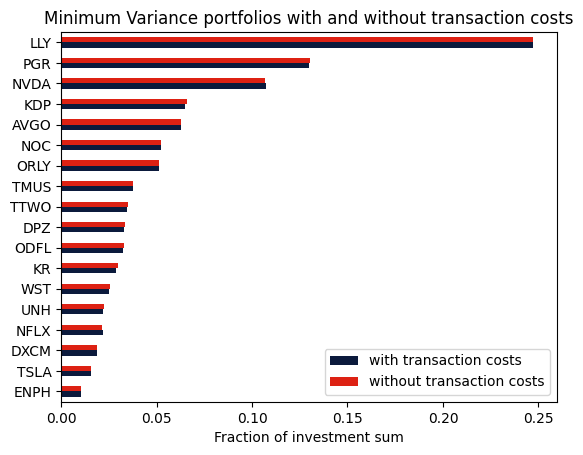

In [13]:
# remove budget constraint
m.remove(budget_constr)
# add new budget constraint without costs
m.addConstr(x.sum() == 1, name="Budget_Constraint")
m.params.OutputFlag = 0
m.optimize()

# retrieve and display solution data
positions_no_costs = pd.Series(name="Position", data=x.X, index=mu.index)
mask = (positions > 1e-5) | (positions_no_costs > 1e-5)
df = pd.DataFrame(
    index=positions[mask].index,
    data={
        "with transaction costs": positions,
        "without transaction costs": positions_no_costs,
    },
).sort_values("with transaction costs", ascending=True)

axs = df.plot.barh(color=["#0b1a3c", "#dd2113"])
axs.set_xlabel("Fraction of investment sum")
plt.title("Minimum Variance portfolios with and without transaction costs")
plt.show()

## Takeaways
* Transaction costs and fees can be incorporated into the basic budget constraint.
* Fixed costs are independent of the traded amount and can be modeled using binary decision variables.
* Variable fees are proportional to the traded amount and can be modeled using continuous decision variables.